# Потоковая обработка / онлайн-алгоритмы

Потоковые алгоритмы (streaming) работают в реальном времени: обработка звука, видео


Когда нужны потоковые алгоритмы:
1. Жесткое требование к минимальной задержке:
   - управление прибором в реальном времени (накачка манжеты, нажатия кнопки и т.д.)
   - прикроватный монитор, формирование тревог
2. Допустима большая задержка, данные приходят кусками время от времени: 
   - телемониторирование
3. Оффлайн-обработка: данные обрабатываются после приема целиком
   - кардиограф (короткая запись)
   - холтеровская запись


## Источники потоковых данных:
- генератор сигнала
- из файла записи
- из прибора (USB)

## Варианты коммуникации:
- симуляция - цикл по отсчетам времени
- из другого процесса (IPC)
  - пайпы
  - сокеты
- сетевые источники (ожидание событий прихода данных)
  - HTTP
  - вебсокеты

Поддержка разных источников данных по одному интерфейсу позволяет отвязать источник от обработки:
- прибор можно заменить файлом и симулировать прием новых данных
- часть алгоритмов можно вынести из прибора и отлаживать обработку в среде, удобной для моделирования

## Варианты потоковой обработки:
1. Поточная обработка
   - обрабатываем новую точку данных (последовательно)
   - храним состояния, всегда опираемся на историю данных
2. Кусочная обработка (batching)
   - обрабатываем новые данные кусками (блоками)
   - блоки можно обрабатывать **независимо** друг от друга (распараллелить)
   - склеиваем границы кусков, чтобы устранить разрывы

! Разделение условное, т.к. кусочная обработка может сводиться к накоплению данных для поточных алгоритмов (тактирование порциями данных).

## Потоковые алгоритмы - из чего состоят
- способ запуска, тактирование (регулярно по времени / по новым данным / по событиям и т.д.)
- настройки - задаются при инициализации
- состояния - меняются по ходу обработки
- входы:
  - приходит новая порция данных
  - одна точка, либо ограничен максимальный размер порции
  - есть необходимая история предыдущих данных (которая буферизуется внутри алгоритма)
- выходы:
  - допустимая задержка (в цепочке алгоритмов их задержки суммируются)



### Пример: Пороговый детектор с гистерезисом по амплитуде

In [1]:
#using Plots, DSP
import Pkg;
Pkg.instantiate()
using Plots, DSP

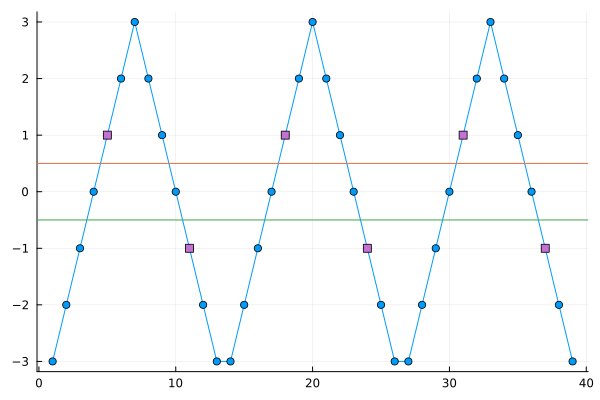

In [2]:
# пороговый детектор событий с гистерезисом по амплитуде
mutable struct ThrDetector{T}
    # настройки
    thr_on::T
    thr_off::T

    # состояния
    counter::Int
    detect_prev::Bool

    # выход
    out::Vector{Int}

    function ThrDetector{T}(thr_on::T, thr_off::T, out::Vector{Int} = Int[]) where T
        new(thr_on, thr_off, 1, false, out)
    end
end

function exe(obj::ThrDetector{T}, x::T) where T
    counter, detect_prev, out = obj.counter, obj.detect_prev, obj.out

    if !detect_prev
        det = x > thr_on
    else
        det = x > thr_off # если уже была детекция, то условие выключения детектора берем по меньшему порогу
    end

    if det != detect_prev # появилось новое событие - пишем его на выход
        push!(out, counter)
    end
    
    obj.counter = counter + 1
    obj.detect_prev = det
    return out
end

# чтобы можно было вызвать скобки от объекта этого типа
function (obj::ThrDetector)(x)
    exe(obj, x)
end

# =============================================

inp = Float64[-3,-2,-1,0,1,2,3,2,1,0,-1,-2,-3] # входной сигнал - массив точек
inp = vcat(inp, inp, inp)

# параметры детектора
thr_on, thr_off = 0.5, -0.5
alg_thr = ThrDetector{Float64}(thr_on, thr_off)

# out = map(detect_threshold, inp)
for i in 1:length(inp)
    x = inp[i]
    exe(alg_thr, x) # аналогично exe(alg_thr, x) 
end

out = alg_thr.out # заполнение выхода теперь вынесено внутрь функции детектора

plot(inp, marker = :circle)
hline!([thr_on])
hline!([thr_off])
scatter!(out, inp[out], marker = :rect, legend = false)

### Пример: Производная

Первая разность c шагом `delta`: 

- `y[i] = x[i] - x[i-delta]`
- задержка фильтра `delta/2`

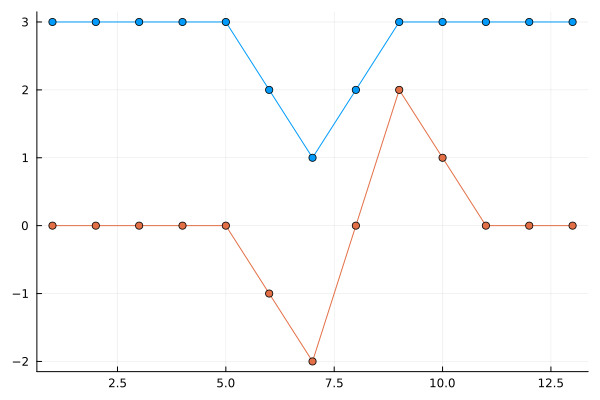

In [3]:
mutable struct DiffFilter{T}
    buf::Vector{T} # буфер предыдущих отсчетов
    k::Int
    need_restart::Bool

    function DiffFilter{T}(delta::Int) where T
        new(fill(T(0), delta), 1, true)
    end
end

function exe(obj::DiffFilter{T}, x::T) where T
    buf, k = obj.buf, obj.k

    if obj.need_restart # инициализация на первой точке
        fill!(buf, x) # заполняем буфер первой точкой
        obj.need_restart = false
    end

    x0 = buf[k]
    y = x - x0

    buf[k] = x
    k += 1
    if k > length(buf)
        k = 1
    end
    
    obj.k = k
    return y
end

inp = Float64[3,3,3,3,3,2,1,2,3,3,3,3,3] # входной сигнал - массив точек
out = fill(0.0, size(inp)) # выход - массив такой же длины

# параметр фильтра:
delta = 2
d_flt = DiffFilter{Float64}(delta)

for i in 1:length(inp)
    out[i] = exe(d_flt, inp[i]) # состояние фильтра - x0, меняется при повторных вызовах функции
end

plot(inp, marker = :circle)
plot!(out, marker = :circle, legend = false)

### Буфер для сохранения истории предыдущих данных

![image](https://user-images.githubusercontent.com/20798349/231397746-937ca399-c11b-42d1-b209-bbd99a8c8e0c.png)

## БИХ и КИХ-фильтры

Линейные фильтры - которые можно представить как линейную комбинацию предыдущих значений:

\begin{equation}
y[n] = \sum_{k=0}^{N-1} b_k x[n-k] - \sum_{k=1}^{M-1} a_k y[n-k]
\end{equation}

iir_filter.jl

### Кольцевой буфер

In [29]:
Pkg.add("DataStructures")
using DataStructures

cb = CircularBuffer{Int}(5)
append!(cb, 1:5)
push!(cb, 6)

   Resolving package versions...


  No Changes to `C:\Users\gvg\YandexDisk\my_course\course-2023-1\lec4-stream-proc\Project.toml`
  No Changes to `C:\Users\gvg\YandexDisk\my_course\course-2023-1\lec4-stream-proc\Manifest.toml`


5-element CircularBuffer{Int64}:
 2
 3
 4
 5
 6

## "Рекурсивная" оптимизация

Можем переиспользовать состояние, вычисленное на предыдущем шаге.
+ (+) можем упростить вычисления
- (-) платим тем, что надо хранить состояние

Например, для скользящих окон - доступны оптимизации:
- преобразование из КИХ в БИХ-фильтр (меньшее количество весов)
- скользящее среднее по крайним точкам
- и т.д.

### Пример: Скользящее среднее в окне `N`
- задержка фильтра = `(N-1)/2`

Рекурсивная оптимизация: выражаем следующее состояние через предыдущее

\begin{align*}
y[i] &= \frac{1}{N} \sum_{k=0}^{N-1} x[i-k] \\

y[i] - y[i-1] &= \frac{1}{N} (\sum_{k=0}^{N-1} x[i-k] - \sum_{k=1}^{N} x[i-k]) \\

y[i] &= y[i-1] + \frac{1}{N} (x[i] - x[i-N]) \\
\end{align*}

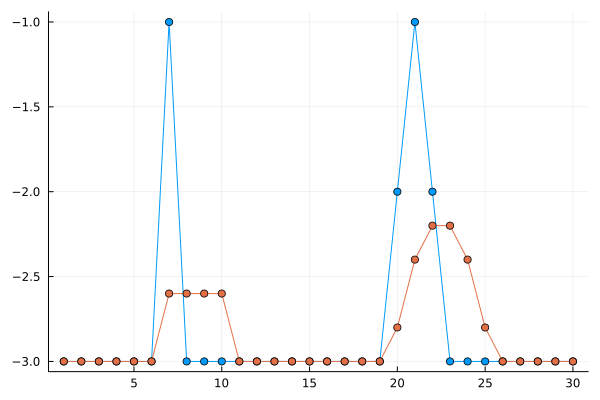

In [9]:
module MOD
# фильтр скользящего среднего
mutable struct SlideMeanFilter{T}
    buf::Vector{T}
    k::Int
    need_restart::Bool
    prev_sum::T
    function SlideMeanFilter{T}(window::Int) where T
        new(fill(T(0), window-1), 1, true)
    end
end

function exe(obj::SlideMeanFilter{T}, x::T) where T
    buf, k = obj.buf, obj.k

    if obj.need_restart # инициализация на первой точке
        fill!(buf, x) # заполняем буфер первой точкой
        obj.need_restart = false
        obj.prev_sum = x
    end
    window = (length(buf) + 1)
    y = obj.prev_sum + ( x - buf[k] ) / window
    # sum_x = x
    # for xi in buf # сумма всех элементов в буфере + 1 новая точка
    #     sum_x += xi
    # end
    # y = sum_x / window # (length(buf) + 1)
    obj.prev_sum = y

    buf[k] = x
    k += 1
    if k > length(buf)
        k = 1
    end
    
    obj.k = k
    return y
end

export SlideMeanFilter, exe
end # module

using .MOD

inp = fill(-3.0, 30) # входной сигнал - массив точек
inp[7] = -1.0
inp[20:22] = [-2.0,-1.0,-2.0]
out = fill(0.0, size(inp)) # выход - массив такой же длины

# параметры фильтра
window = 5

slide_flt = MOD.SlideMeanFilter{Float64}(window)

for i in 1:length(inp)
    x = inp[i]
    y = MOD.exe(slide_flt, x)
    out[i] = y
end

plot(inp, marker = :circle)
plot!(out, marker = :circle, legend = false)

## Форматы хранения (файлов):
- текст (например, CSV)
- бинарные форматы (bin+hdr, physionet, edf и т.д.)
- SQL - реляционные таблицы
- HDF5 - многомерные массивы со сжатием по блокам
- Parquet - колоночная таблица со сжатием по блокам

Что можем сохранять: результаты обработки, состояния алгоритма для продолжения обработки.